In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    https://github.com/tylersco/deep-neural-networks-art-images
    http://www.scipy-lectures.org/advanced/image_processing/
"""
from scipy import misc
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import pandas as pd
import csv
import math
from __future__ import division, print_function, absolute_import
from data.img.ArtDataLoader import ArtData
from Plotter import plot_acc_distance
from Plotter import plot_acc_cosine
from Plotter import plot_prob_distance_2lists
from Plotter import plot_prob_cosine_2lists
from Plotter import plot_acc_distance_2lists
from Plotter import plot_acc_cosine_2lists
from Plotter import plot_prob_distance_4lists
from Plotter import plot_prob_cosine_4lists
from Plotter import plot_acc_distance_4lists
from Plotter import plot_acc_cosine_4lists
from MySpearman import get_correlation_distance
from MySpearman import get_correlation_cosine
from scipy.stats import spearmanr

In [2]:
from scipy import misc
art_data = ArtData()
art_data.load_all_data()
#art_data.load_images()
#art_data.load_metadata()

ArtData Initialized!
2592  images loaded!


In [3]:
#print(art_data.train_images.keys())
#Validate
print(art_data.alpha_pairs['same'][0][95])
print(art_data.beta_pairs['same'][0][95])

print(art_data.alpha_pairs['diff'][0][95])
print(art_data.beta_pairs['diff'][0][95])

2018-impressionist-16x16.jpg
2134-impressionist-16x16.jpg
1233-cubist-16x16.jpg
1185-cubist-16x16.jpg


In [4]:
print(art_data.train_images['0001-cubist-16x16.jpg'].shape)

(16, 16, 3)


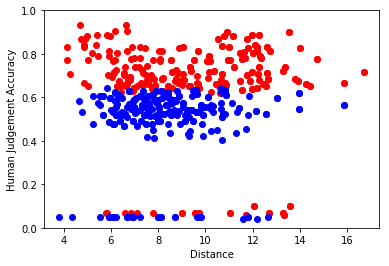

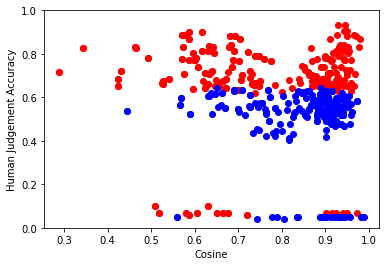

In [5]:
#Raw data
plot_acc_distance(art_data)
plot_acc_cosine(art_data)

In [6]:
get_correlation_distance(art_data)

SpearmanrResult(correlation=-0.4531196797090763, pvalue=1.6549967874513576e-30)

In [7]:
get_correlation_cosine(art_data)

SpearmanrResult(correlation=0.42701803307779929, pvalue=6.2551843304760119e-27)

In [ ]:
#start of autoencoder
'''
Reference:
https://github.com/MorvanZhou/tutorials/edit/master/tensorflowTUT/tf21_autoencoder/full_code.py
My tutorial website: https://morvanzhou.github.io/tutorials/
'''
learning_rate = 0.01
training_epochs = 100
batch_size = 256
display_step = 5
# Network Parameters
n_input = 768 # image data input (img shape: 16*16*3)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 384 # 1st layer num features
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    return layer_1

In [ ]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
y_bottleneck = encoder_op

# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(len(art_data.train_images) / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = art_data.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    
    #alpha
    encode_output_alpha_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_output_alpha_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    encode_decode_output_alpha_a = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_decode_output_alpha_b = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    #beta
    encode_output_beta_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_output_beta_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[1]})
    
    encode_decode_output_beta_a = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_decode_output_beta_b = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[1]})
  
encode_outout_alpha_a = encode_output_alpha_a.tolist()
encode_output_alpha_b = encode_output_alpha_b.tolist()

encode_decode_output_alpha_a = encode_decode_output_alpha_a.tolist()
encode_decode_output_alpha_b = encode_decode_output_alpha_b.tolist()

encode_output_beta_a = encode_output_beta_a.tolist()
encode_output_beta_b = encode_output_beta_b.tolist()

encode_decode_output_beta_a = encode_decode_output_beta_a.tolist()
encode_decode_output_beta_b = encode_decode_output_beta_b.tolist()

Epoch: 0001 cost= 0.221733689
Epoch: 0006 cost= 0.106533803
Epoch: 0011 cost= 0.097118847
Epoch: 0016 cost= 0.103847675
Epoch: 0021 cost= 0.098916173
Epoch: 0026 cost= 0.098677196
Epoch: 0031 cost= 0.100138880
Epoch: 0036 cost= 0.095589779
Epoch: 0041 cost= 0.095919468
Epoch: 0046 cost= 0.091081738
Epoch: 0051 cost= 0.090167403
Epoch: 0056 cost= 0.089907028
Epoch: 0061 cost= 0.092208326
Epoch: 0066 cost= 0.082246065
Epoch: 0071 cost= 0.089803003
Epoch: 0076 cost= 0.089225322
Epoch: 0081 cost= 0.088716827
Epoch: 0086 cost= 0.091875769
Epoch: 0091 cost= 0.088743471


In [ ]:
#alpha

In [ ]:
#alpha, bottleneck output, distance, cosine, prob_human_similarity
encode_output_alpha_distance = art_data.get_distance_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
encode_output_alpha_cosine = art_data.get_cosine_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
plot_acc_distance_2lists(encode_output_alpha_distance, art_data.alpha_accuracy)
plot_acc_cosine_2lists(encode_output_alpha_cosine, art_data.alpha_accuracy)

In [ ]:
#alpha, bottleneck output, distance, prob_human_similarity
spearmanr(encode_output_alpha_distance, art_data.alpha_accuracy, axis=None)

In [ ]:
#alpha, bottleneck output, cosine, prob_human_similarity
spearmanr(encode_output_alpha_cosine, art_data.alpha_accuracy, axis=None)

In [ ]:
#alpha, network output, distance, cosine, prob_human_similarity
encode_decode_output_alpha_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
encode_decode_output_alpha_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
plot_acc_distance_2lists(encode_decode_output_alpha_distance, art_data.alpha_accuracy)
plot_acc_cosine_2lists(encode_decode_output_alpha_cosine, art_data.alpha_accuracy)

In [ ]:
#alpha, network output, distance, prob_human_similarity
spearmanr(encode_decode_output_alpha_distance, art_data.alpha_accuracy, axis=None)

In [ ]:
#alpha, network output, cosine, prob_human_similarity
spearmanr(encode_decode_output_alpha_cosine, art_data.alpha_accuracy, axis=None)

In [ ]:
#beta

In [ ]:
#beta, bottleneck output, distance, cosine, prob_human_similarity
encode_output_beta_distance = art_data.get_distance_list_flatten(encode_output_beta_a, encode_output_beta_b)
encode_output_beta_cosine = art_data.get_cosine_list_flatten(encode_output_beta_a, encode_output_beta_b)
plot_acc_distance_2lists(encode_output_beta_distance, art_data.beta_accuracy)
plot_acc_cosine_2lists(encode_output_beta_cosine, art_data.beta_accuracy)

In [ ]:
#beta, bottleneck output, distance, prob_human_similarity
spearmanr(encode_output_beta_distance, art_data.beta_accuracy, axis=None)

In [ ]:
#beta, bottleneck output, cosine, prob_human_similarity
spearmanr(encode_output_beta_cosine, art_data.beta_accuracy, axis=None)

In [ ]:
#beta, network output, distance, cosine, prob_human_similarity
encode_decode_output_beta_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
encode_decode_output_beta_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
plot_acc_distance_2lists(encode_decode_output_beta_distance, art_data.beta_accuracy)
plot_acc_cosine_2lists(encode_decode_output_beta_cosine, art_data.beta_accuracy)

In [ ]:
#beta, network output, distance, prob_human_similarity
spearmanr(encode_decode_output_beta_distance, art_data.beta_accuracy, axis=None)

In [ ]:
#beta, network output, cosine, prob_human_similarity
spearmanr(encode_decode_output_beta_cosine, art_data.beta_accuracy, axis=None)

In [ ]:
#alpha & beta

In [ ]:
#alpha & beta bottleneck output, distance, cosine, prob_human_similarity
encode_output_distance = []
encode_output_distance.extend(encode_output_alpha_distance)
encode_output_distance.extend(encode_output_beta_distance)

encode_output_cosine = []
encode_output_cosine.extend(encode_output_alpha_cosine)
encode_output_cosine.extend(encode_output_beta_cosine)

accuracy = []
accuracy.extend(art_data.alpha_accuracy)
accuracy.extend(art_data.beta_accuracy)

plot_acc_distance_4lists(encode_output_alpha_distance, art_data.alpha_accuracy,
                            encode_output_beta_distance, art_data.beta_accuracy)
plot_acc_cosine_4lists(encode_output_alpha_cosine, art_data.alpha_accuracy,
                           encode_output_beta_cosine, art_data.beta_accuracy)

In [ ]:
#alpha & beta, bottlenect output, distance, prob_human_similarity
spearmanr(encode_output_distance, accuracy, axis=None)

In [ ]:
#alpha & beta, bottlenect output, cosine, prob_human_similarity
spearmanr(encode_output_cosine, accuracy, axis=None)